In [132]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt



num_of_clusters = 5

ToolName = 'scanpy' 
DatasetName = 'tabula-muris-heart'
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)

if not os.path.exists(save_path):
    os.makedirs(save_path)


# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [133]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

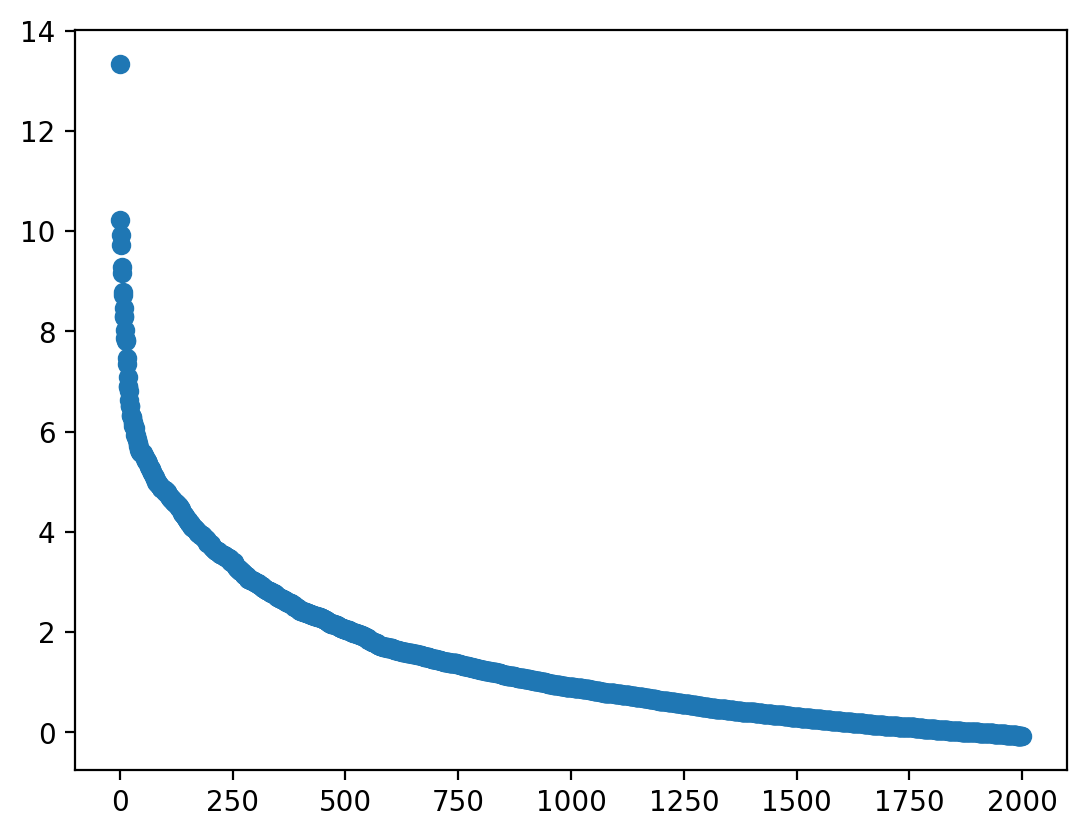

In [134]:
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:2000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [135]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [136]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


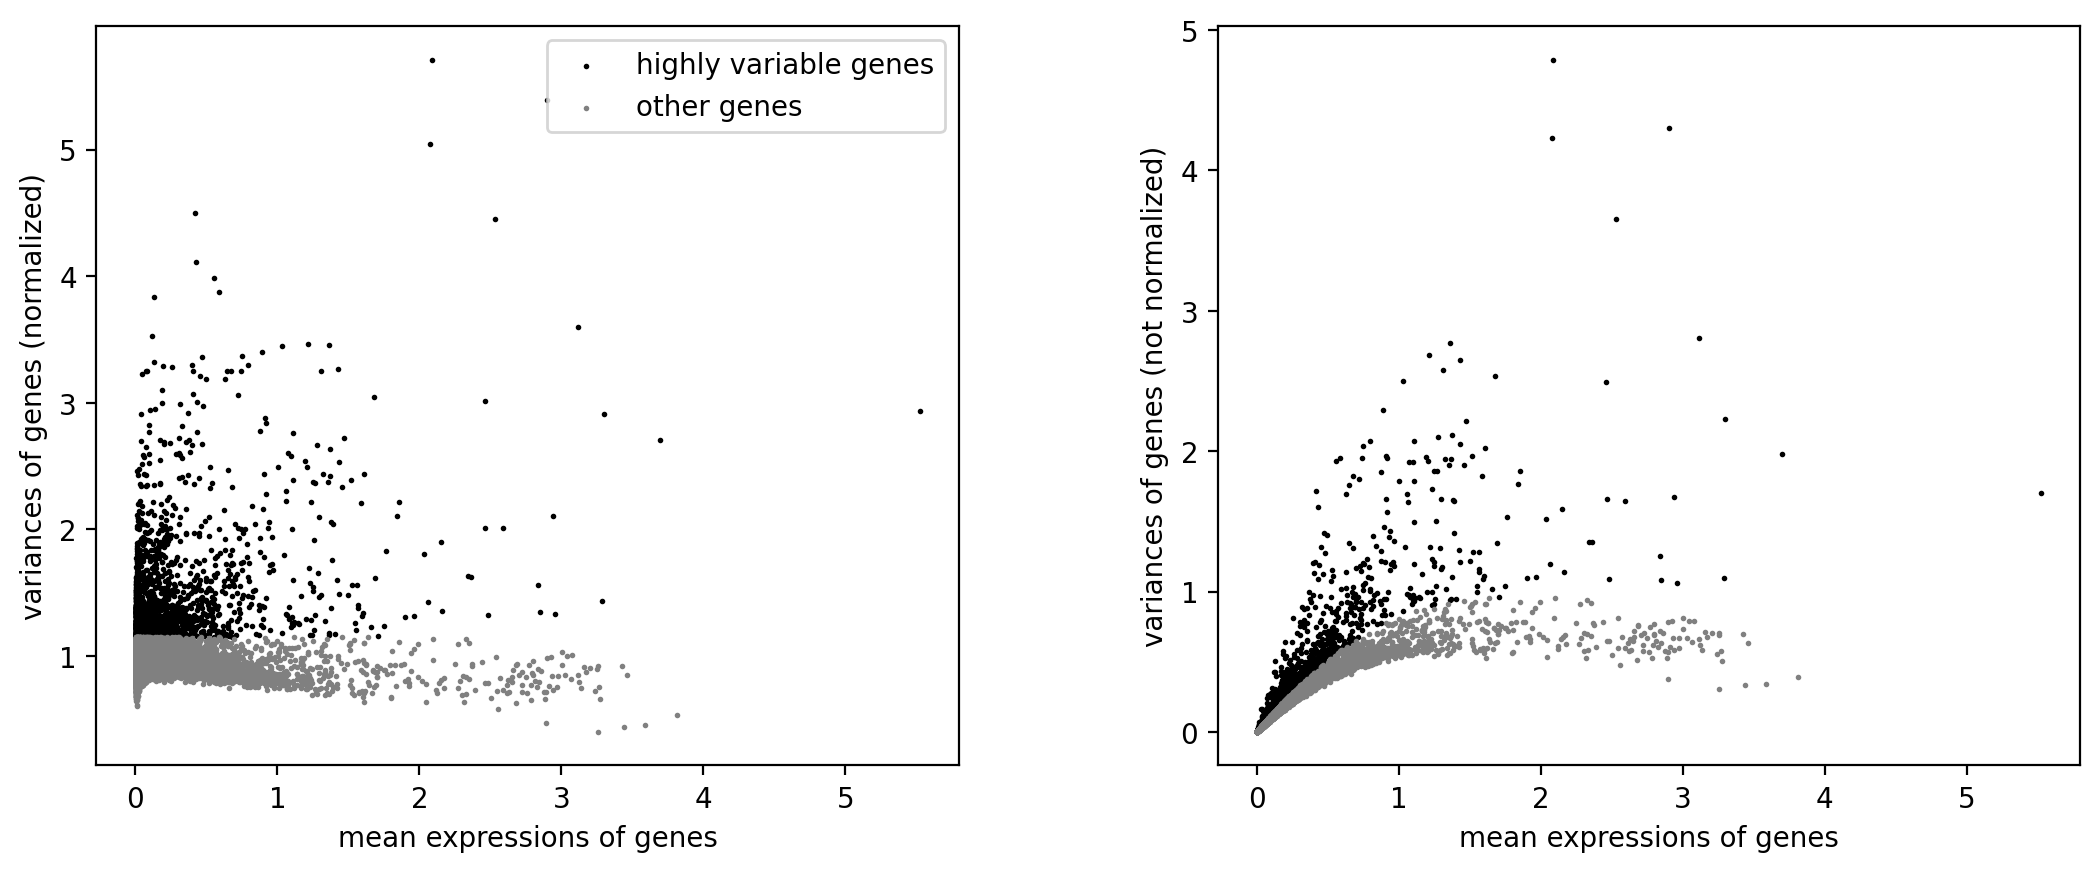

In [137]:
sc.pl.highly_variable_genes(adata)

In [138]:
sc.pp.scale(adata, max_value=10)

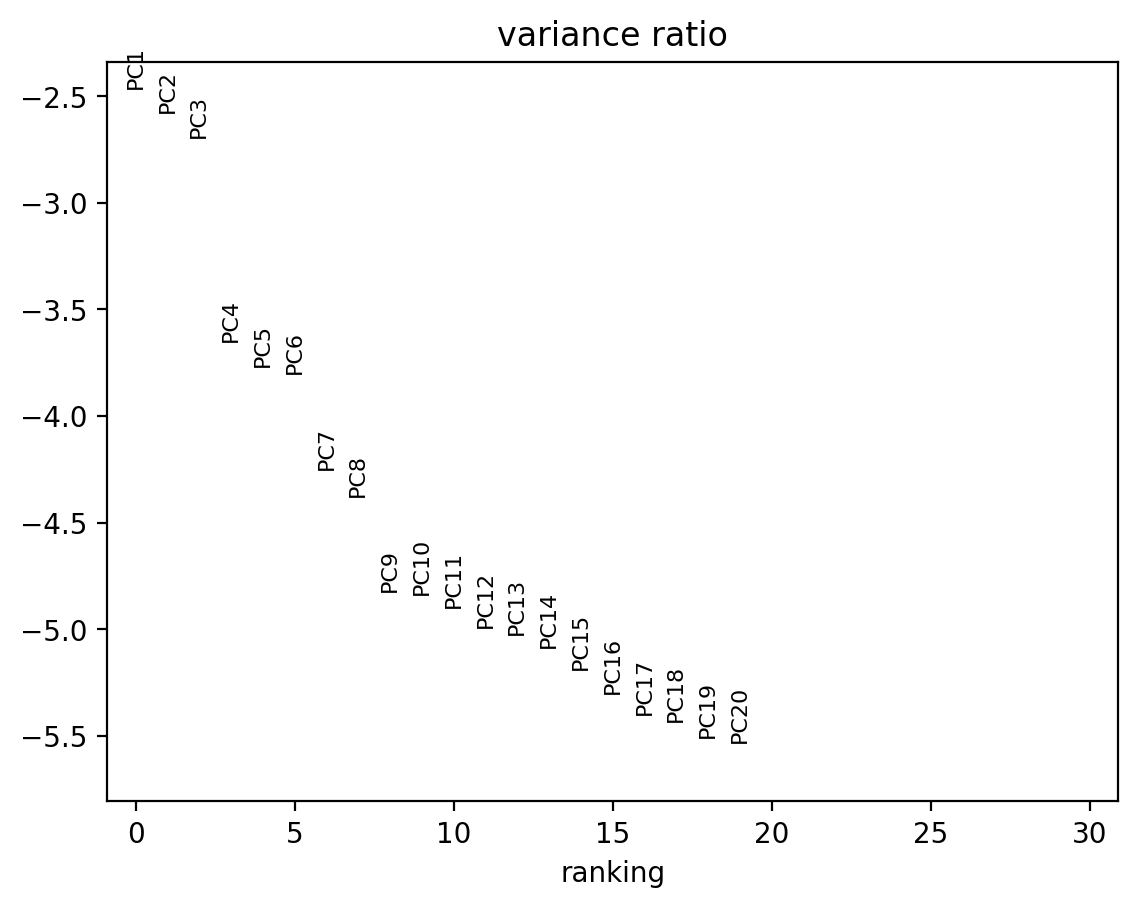

In [139]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


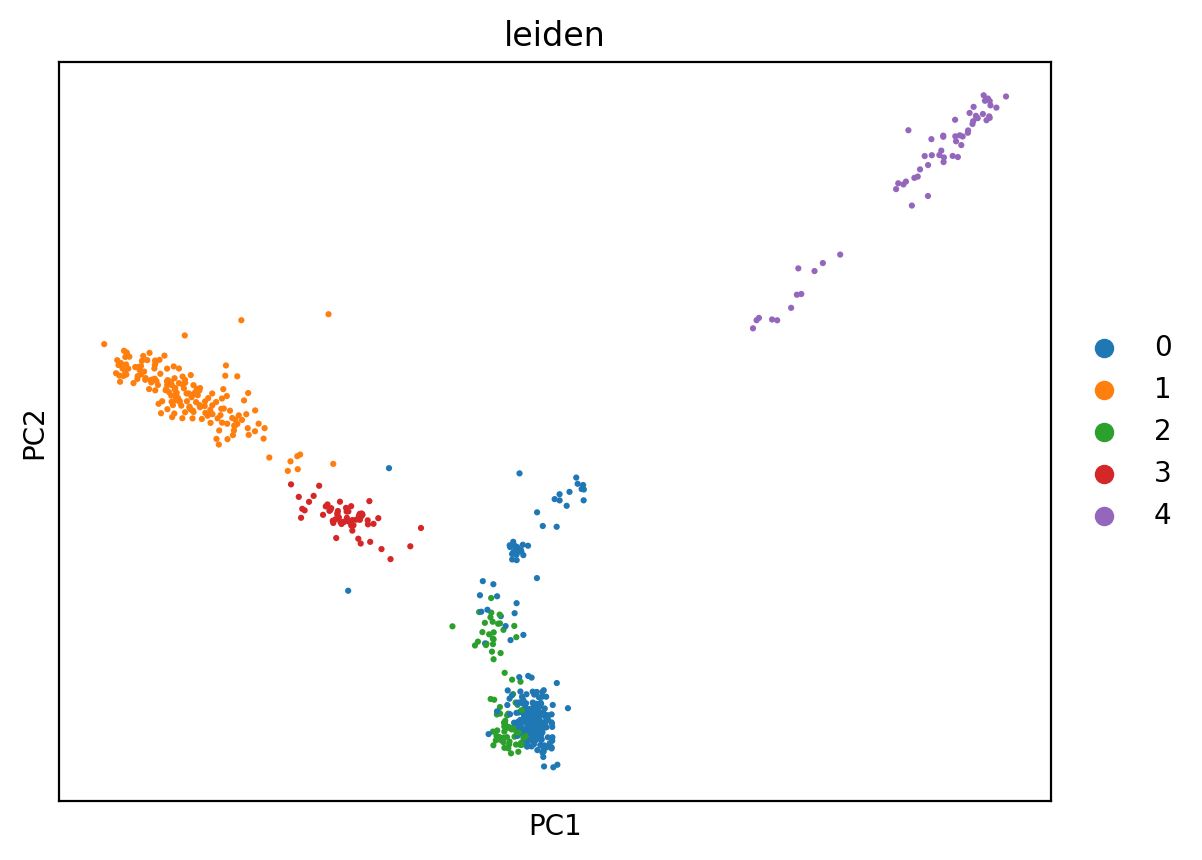

In [141]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)    # 15 è il default di scanpy

res = 0.001
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters, ) or res == 1.0:
    res += 0.005
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [37]:
# cluster id for each cell renamed as cluster

df = pd.DataFrame(adata.obs['leiden'])

labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'

labels['cluster'] = labels['cluster'].astype(int) + 1

labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

In [38]:
# silouhette score
#matrix = adata.X
#
#from sklearn.metrics import silhouette_score
#score = silhouette_score(matrix, labels, metric='euclidean')
#
## dataset with silouette score
#
#df = pd.DataFrame([score], columns=['silhouette'])
#df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/matteo/miniconda3/envs/chl/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name,

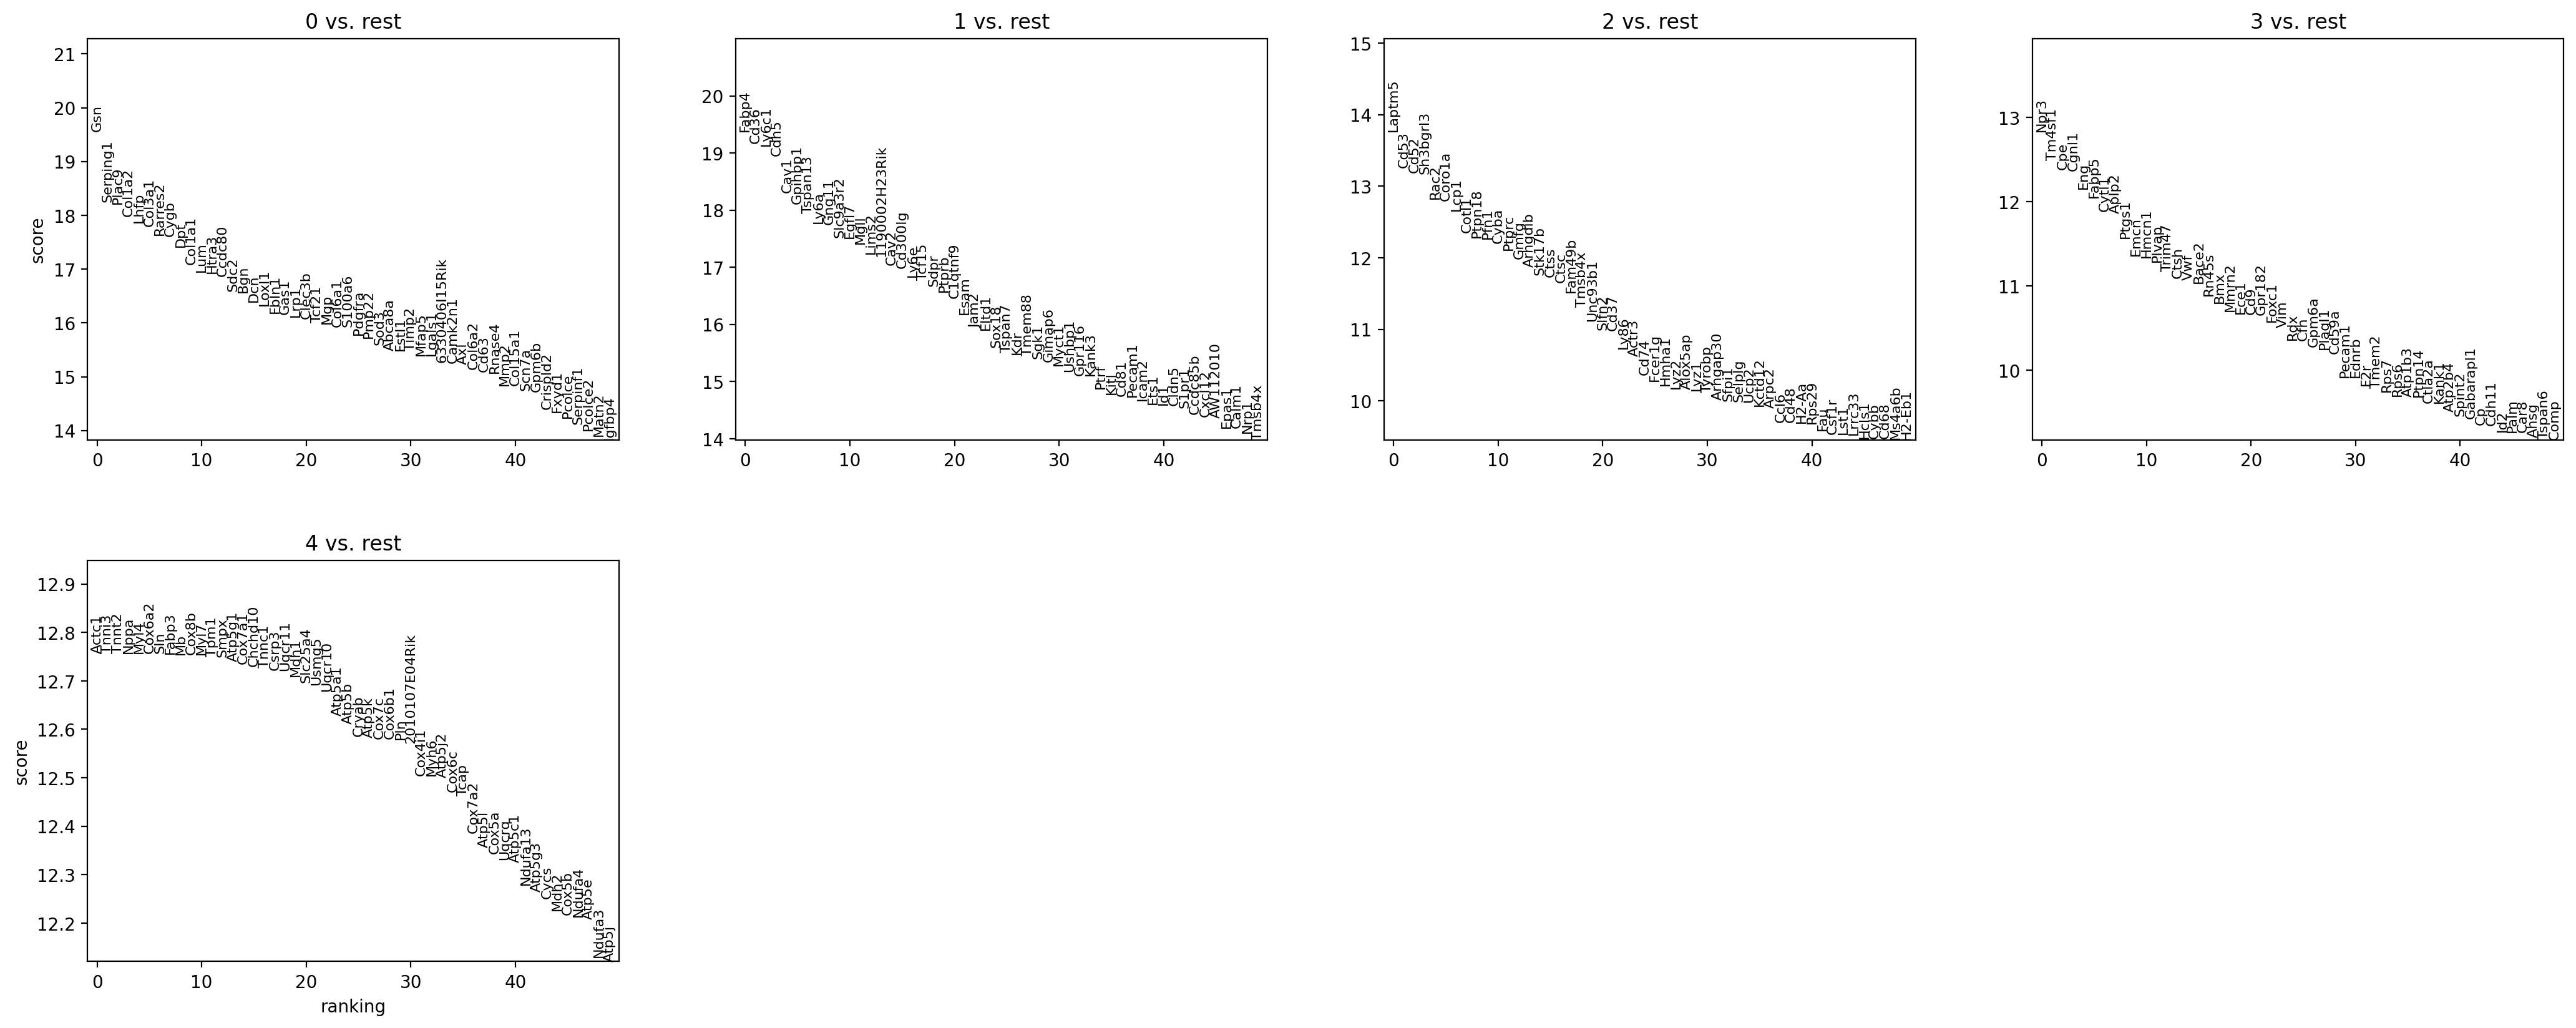

In [142]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') 

In [143]:
number_of_genes = 50

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)